In [1]:
# Example parameters
#ddir= "/users/avsec/workspace/basepair/data/"
#model_file = f"{ddir}/processed/chipnexus/exp/models/oct-sox-nanog-klf/models/filters=128/model.h5"
#dataspec_file = f"{ddir}/processed/chipnexus/exp/models/oct-sox-nanog-klf/models/filters=128/dataspec.yaml"
#history_file = f"{ddir}/processed/chipnexus/exp/models/oct-sox-nanog-klf/models/filters=128/history.csv"
#peak_width = 1000
#seq_width = peak_width
#gpu = 0
#num_workers = 10

In [4]:
import basepair
import pandas as pd
import numpy as np
from basepair.cli.schemas import DataSpec, TaskSpec
from pathlib import Path
from keras.models import load_model
from basepair.config import create_tf_session, get_data_dir
from basepair.datasets import StrandedProfile
from basepair.preproc import AppendCounts
from basepair.losses import MultichannelMultinomialNLL
from basepair.config import valid_chr, test_chr
from basepair.plots import regression_eval, plot_loss
from basepair.cli.evaluate import eval_profile
from basepair import samplers 
from basepair.math import softmax

#ddir = get_data_dir()

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
create_tf_session("")  # don't use gpu

In [4]:
model = load_model(model_file)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2018-08-17 17:59:06,788 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
Use the retry module or similar alternatives.


2018-08-17 17:59:11,147 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


## Learning curves

In [5]:
ds = DataSpec.load(dataspec_file)
tasks = list(ds.task_specs)

In [6]:
# Best metrics
dfh = pd.read_csv(history_file)
dict(dfh.iloc[dfh.val_loss.idxmin()])

{'epoch': 8.0,
 'counts/Klf4_loss': 0.5763918246795969,
 'counts/Nanog_loss': 0.8085860860684356,
 'counts/Oct4_loss': 0.5075312024131083,
 'counts/Sox2_loss': 0.3166249087726566,
 'loss': 2880.5121342164653,
 'profile/Klf4_loss': 662.7736391015776,
 'profile/Nanog_loss': 729.8697500873072,
 'profile/Oct4_loss': 897.3882156169534,
 'profile/Sox2_loss': 568.3891731746264,
 'val_counts/Klf4_loss': 0.5700172278456918,
 'val_counts/Nanog_loss': 0.7616309322774691,
 'val_counts/Oct4_loss': 0.4700713822346144,
 'val_counts/Sox2_loss': 0.2803601254105069,
 'val_loss': 2948.583722377365,
 'val_profile/Klf4_loss': 664.730172431606,
 'val_profile/Nanog_loss': 764.6310811588037,
 'val_profile/Oct4_loss': 916.285162450171,
 'val_profile/Sox2_loss': 582.1165091954679}

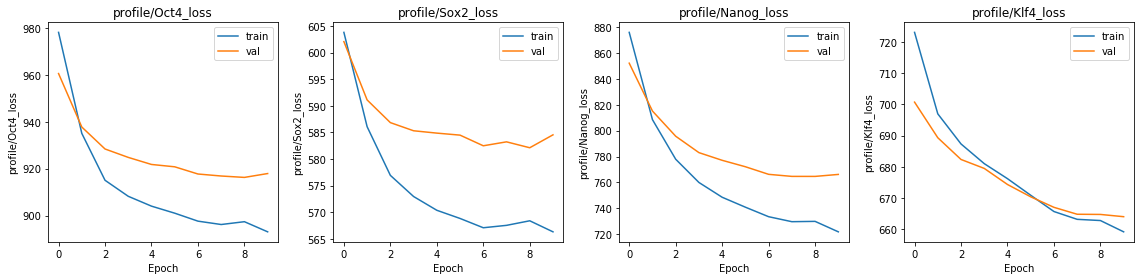

In [7]:
plot_loss(dfh, [f"{p}/{task}_loss"
                for task in tasks
                for p in ['profile']
               ], figsize=(len(tasks)*4, 4))

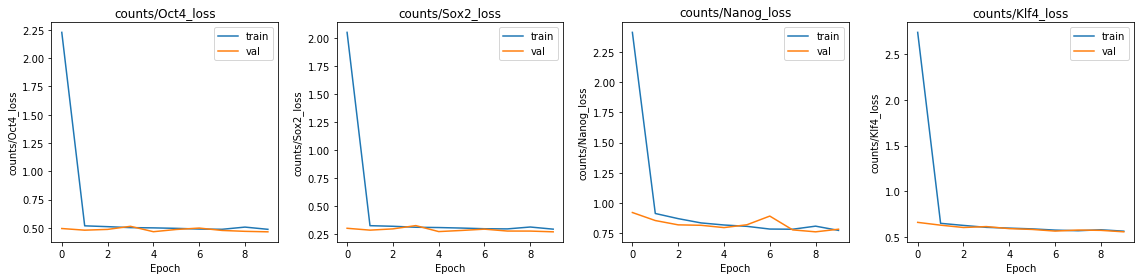

In [8]:
plot_loss(dfh, [f"{p}/{task}_loss"
                for task in tasks
                for p in ['counts']
               ], figsize=(len(tasks)*4, 4))

## Evaluation

In [9]:
dl_valid = StrandedProfile(ds, 
                          incl_chromosomes=valid_chr, 
                          peak_width=peak_width,
                          seq_width=seq_width,
                          shuffle=False,
                          target_transformer=AppendCounts())

In [10]:
valid = dl_valid.load_all(num_workers=num_workers)
y_true = valid["targets"]

100%|██████████| 599/599 [00:04<00:00, 146.32it/s]


In [11]:
from basepair.BPNet import BiasModel

In [12]:
# if [task for task, task_spec in ds.task_specs.items() if task_spec.bias_model]:
#     bm = BiasModel(ds)
#     valid['inputs'] = bm.predict([valid["inputs"]])[0]

In [13]:
y_pred = model.predict(valid['inputs'], verbose=1)

19137/19137 [==============================] - 8s 416us/step


In [14]:
import matplotlib.pyplot as plt

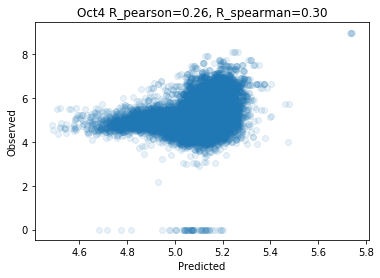

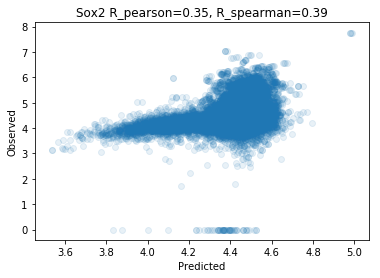

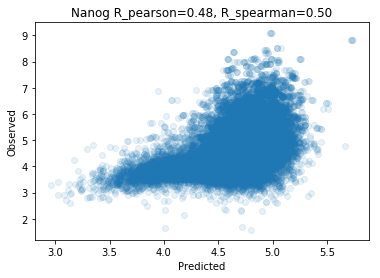

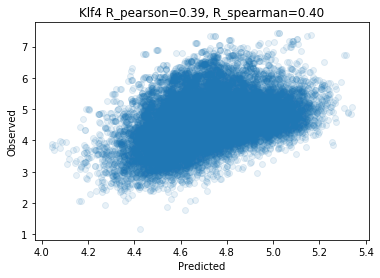

In [15]:
for task in tasks:
    plt.figure()
    yt = y_true[f'counts/{task}'].mean(-1)
    yp = y_pred[ds.task2idx(task, 'counts')].mean(-1)
    regression_eval(yt, 
                    yp, alpha=0.1, task=task)

## Profile evaluation

In [18]:
from joblib import Parallel, delayed
import basepair

In [22]:
task=tasks[0]

In [23]:
yp = softmax(y_pred[ds.task2idx(task, "profile")])
yt = y_true["profile/" + task]

In [24]:
x = np.ravel(yt / (1+yt.sum(axis=-2, keepdims=True)))

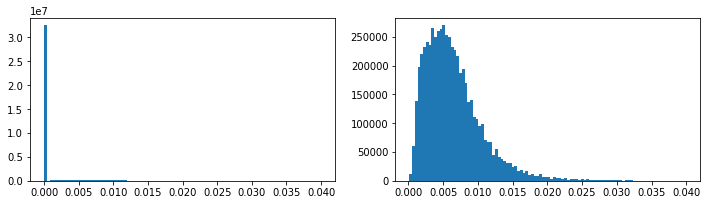

In [25]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.hist(x[(x<0.04) ], bins=100);
plt.subplot(122)
plt.hist(x[(x<0.04) & (x>0.0001)], bins=100);

In [26]:
np.mean(x>0.0001)

0.1517862517635993

In [23]:
out_df = Parallel(n_jobs=len(tasks))(delayed(basepair.cli.evaluate.eval_profile)(y_true["profile/" + task], 
                                                                                 softmax(y_pred[ds.task2idx(task, "profile")]), 
                                                                                 binsizes=[1,10],
                                                                                 pos_min_threshold=0.015,
                                                                                 neg_max_threshold=0.005,)
                 for task in tasks)
df = pd.concat([out_df[i].assign(task=task) for i,task in enumerate(tasks)])

/users/avsec/workspace/basepair/basepair/cli/evaluate.py:147: RuntimeWarning: invalid value encountered in true_divide
  fracs = yt / yt.sum(axis=1, keepdims=True)
/users/avsec/workspace/basepair/basepair/cli/evaluate.py:148: RuntimeWarning: invalid value encountered in greater_equal
  is_peak = (fracs >= pos_min_threshold).astype(float)
/users/avsec/workspace/basepair/basepair/cli/evaluate.py:149: RuntimeWarning: invalid value encountered in less
  ambigous = (fracs < pos_min_threshold) & (fracs >= neg_max_threshold)
/users/avsec/workspace/basepair/basepair/cli/evaluate.py:149: RuntimeWarning: invalid value encountered in greater_equal
  ambigous = (fracs < pos_min_threshold) & (fracs >= neg_max_threshold)
/users/avsec/workspace/basepair/basepair/cli/evaluate.py:147: RuntimeWarning: invalid value encountered in true_divide
  fracs = yt / yt.sum(axis=1, keepdims=True)
/users/avsec/workspace/basepair/basepair/cli/evaluate.py:148: RuntimeWarning: invalid value encountered in greater_equa

In [1]:
# make sure to print all the rows
print(df.to_string())

NameError: name 'df' is not defined

In [ ]:
df.to_csv("model/auprc.metrics.csv")

## Profile plots

In [27]:
from basepair.plots import plot_profiles
from basepair import samplers

In [28]:
tasks = list(ds.task_specs)
task = tasks[0]

In [29]:
#idx_list = samplers.top_sum_count(y_true['profile/Nanog'], 10)

In [30]:
#idx_list = samplers.top_sum_count(y_true['profile/Oct4'], 10)

In [31]:
# Total sum
#idx_list = samplers.top_sum_count(sum([y_true[f'profile/{task}'].mean(-1) for task in tasks])[:,:,np.newaxis], 10)

In [32]:
#idx_list = samplers.top_max_count(y_true['profile/Oct4'], 10)

In [33]:
np.random.seed(42)
idx_list = samplers.random(y_true[f'profile/{task}'], 20, )

In [34]:
idx_list[:4]

[12650, 11668, 8499, 11526]

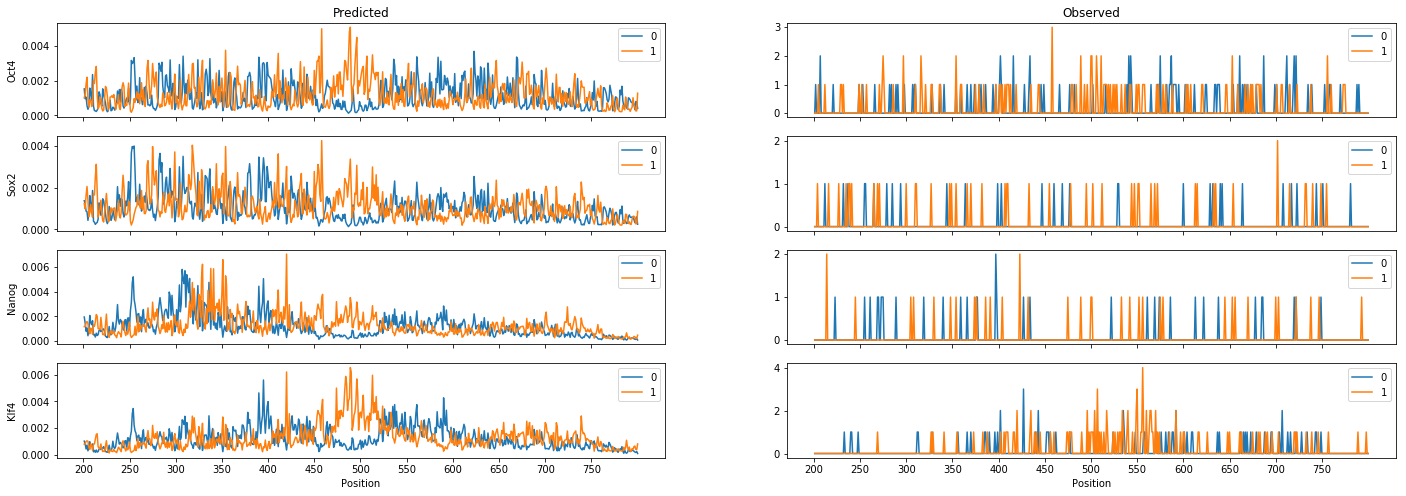

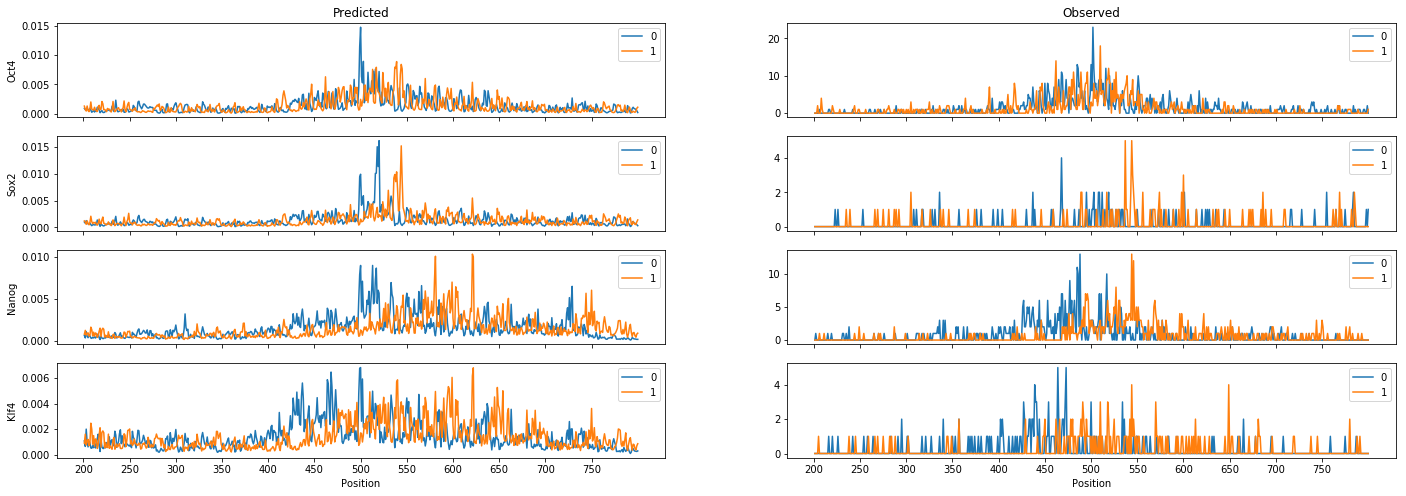

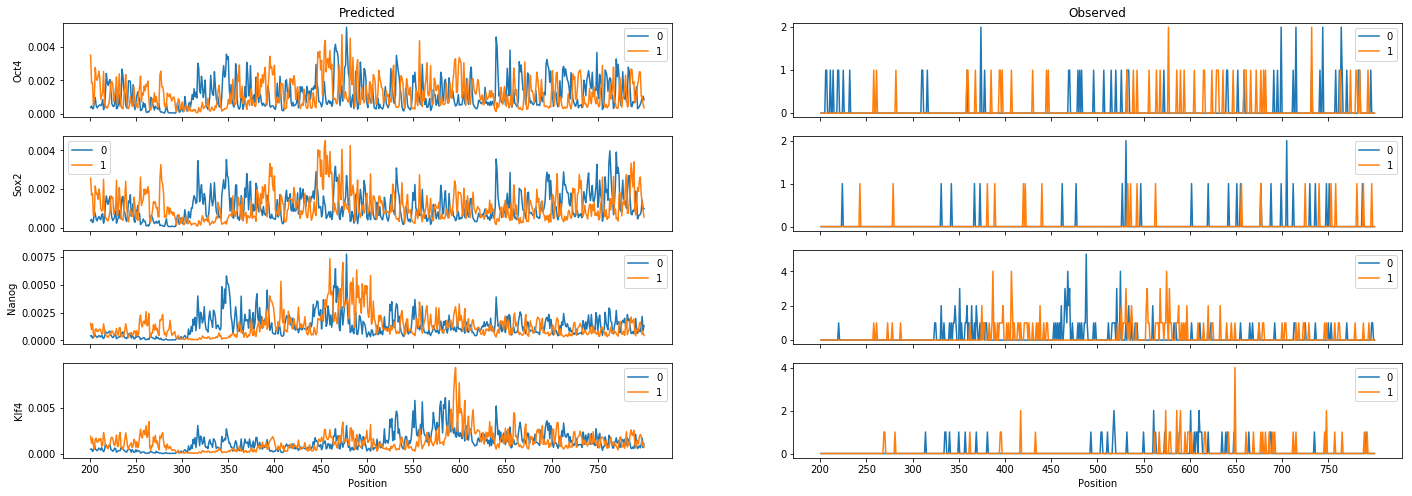

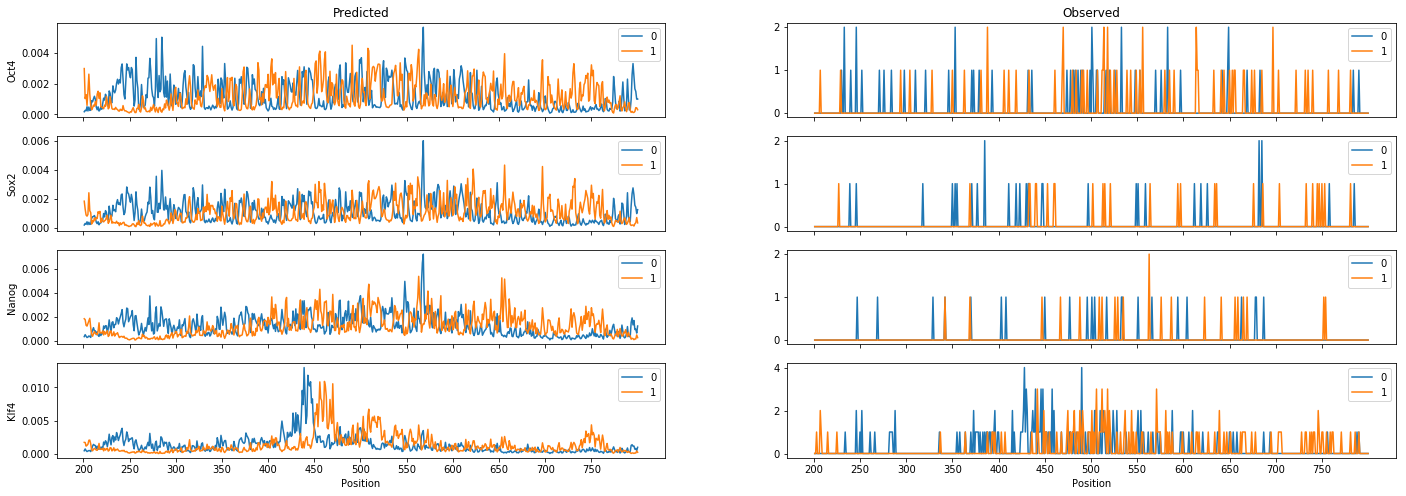

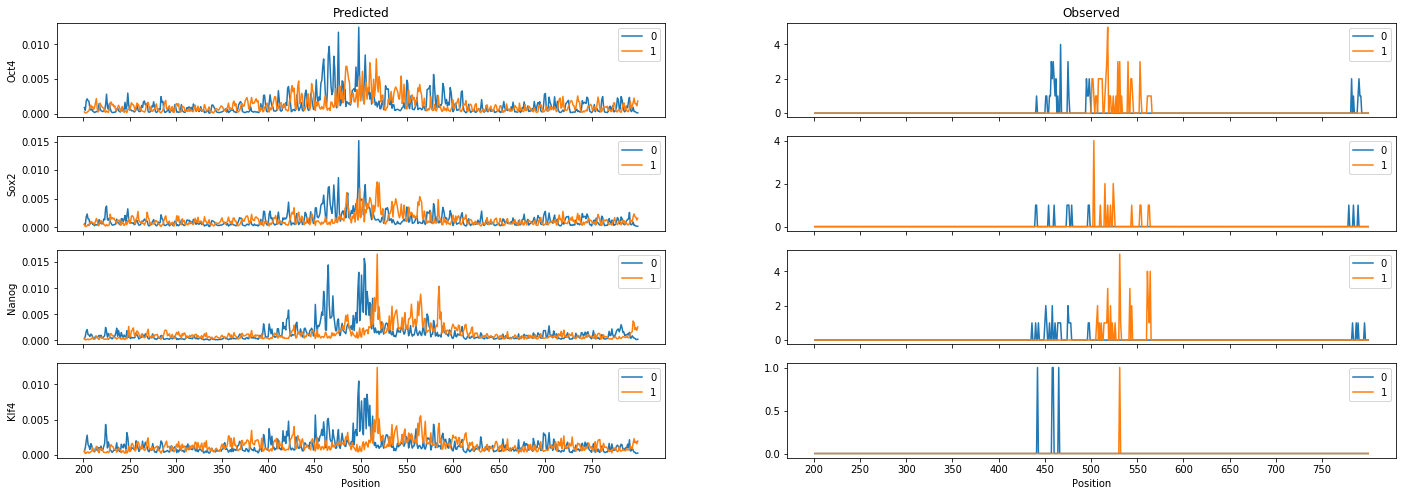

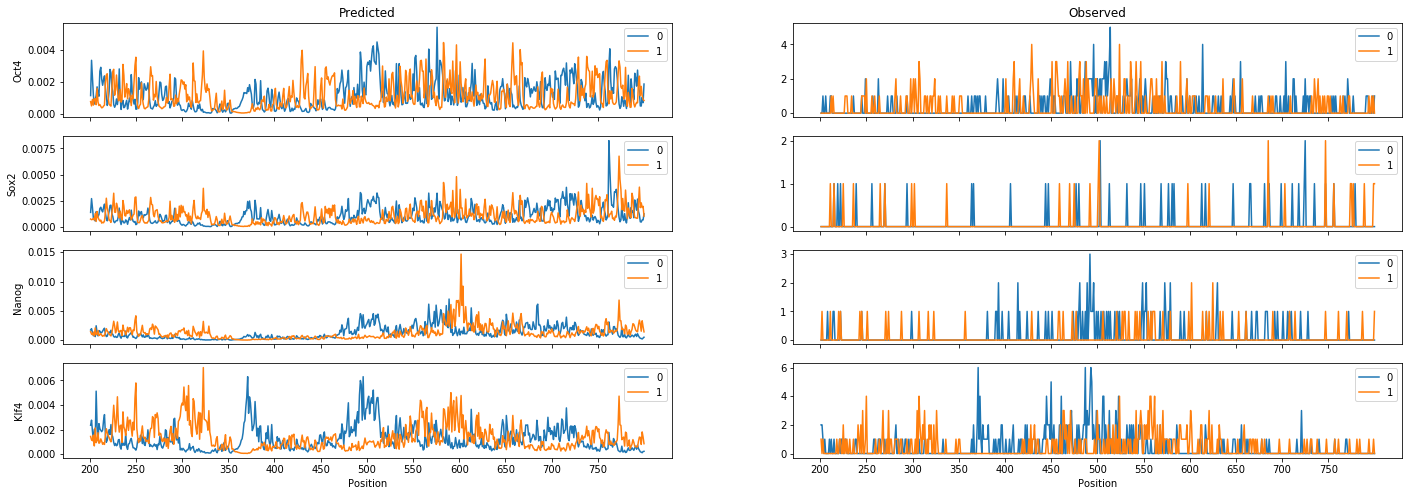

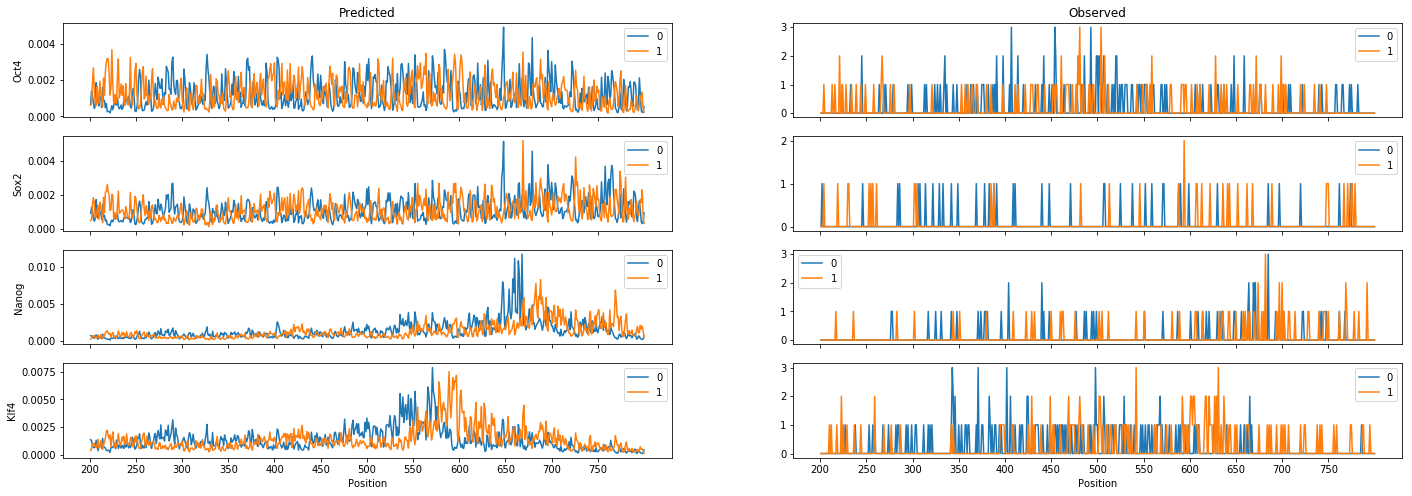

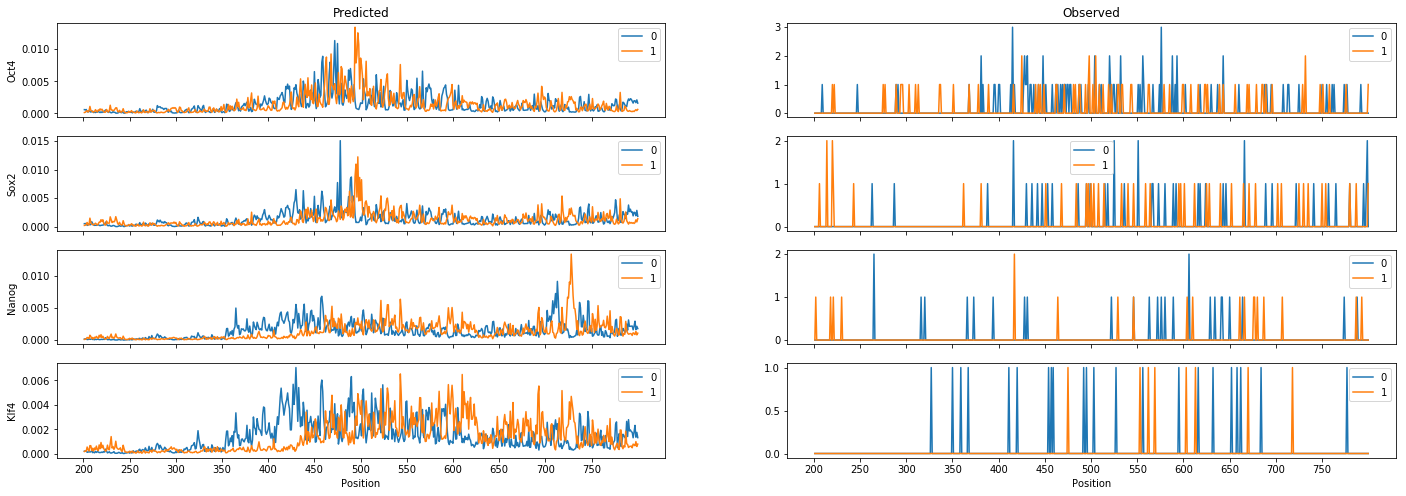

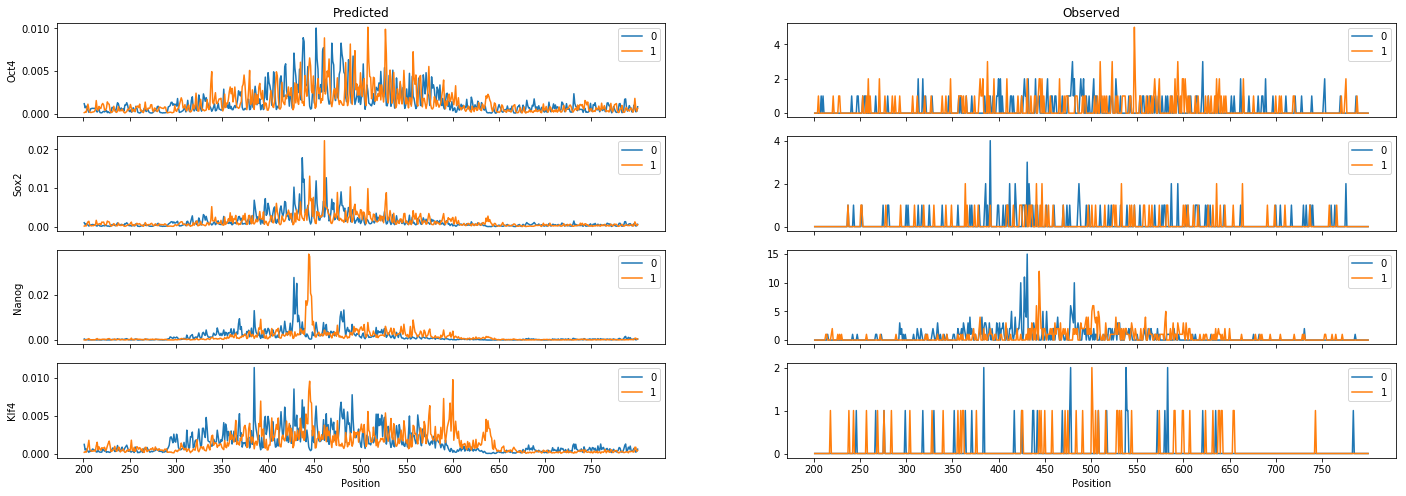

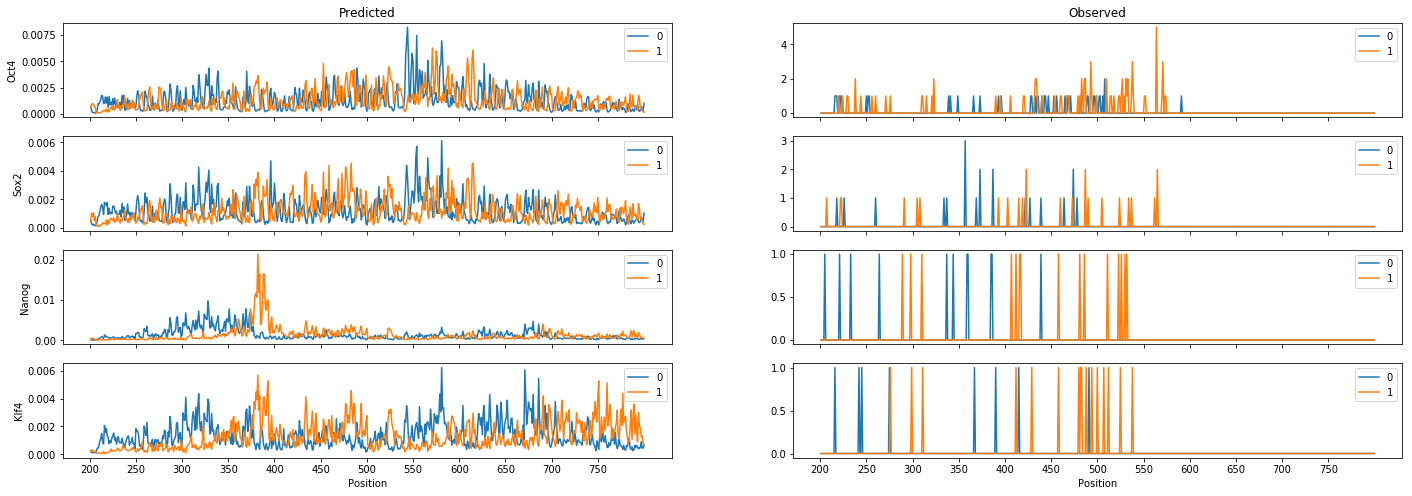

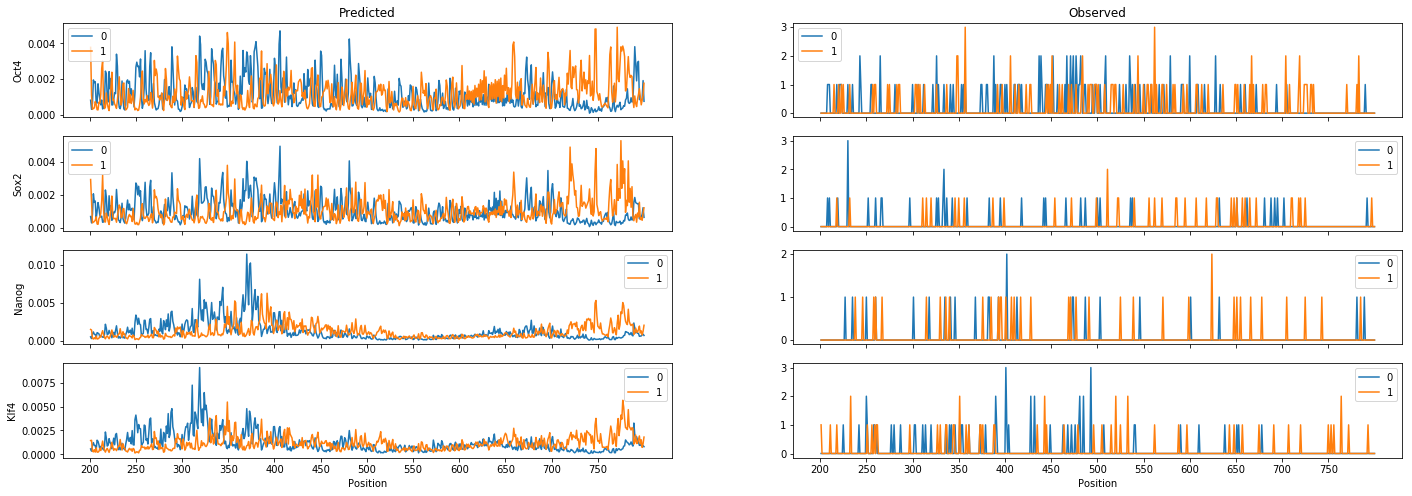

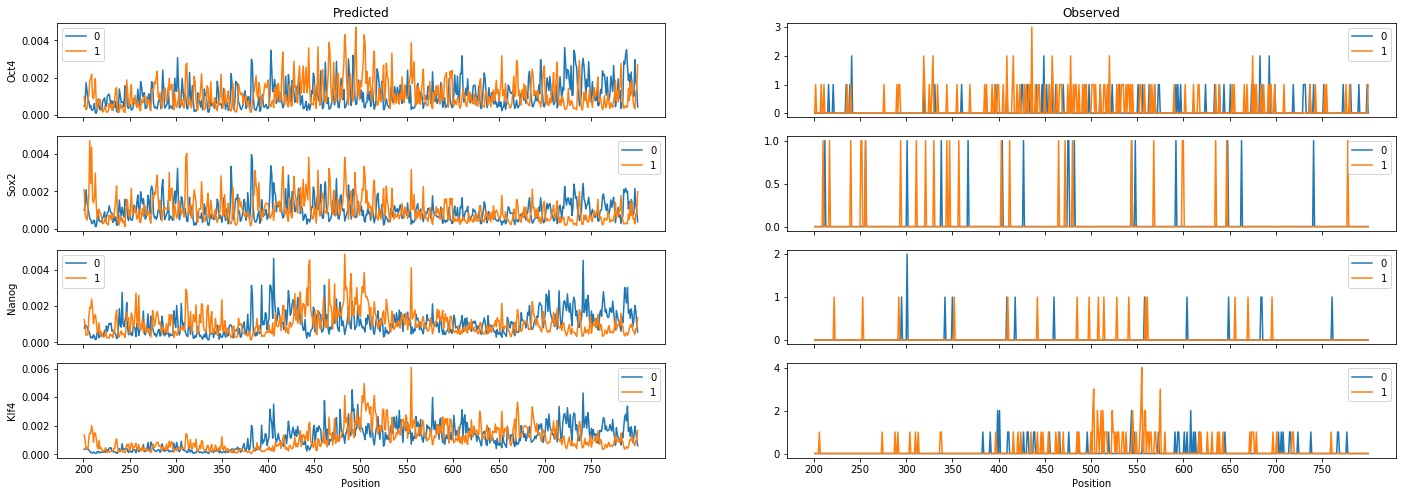

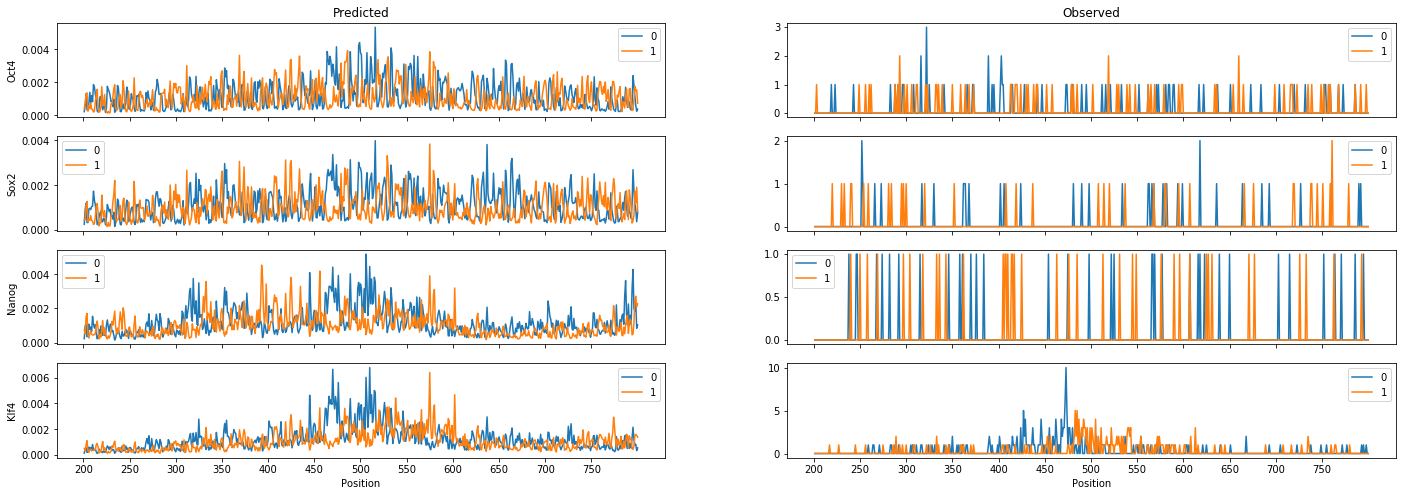

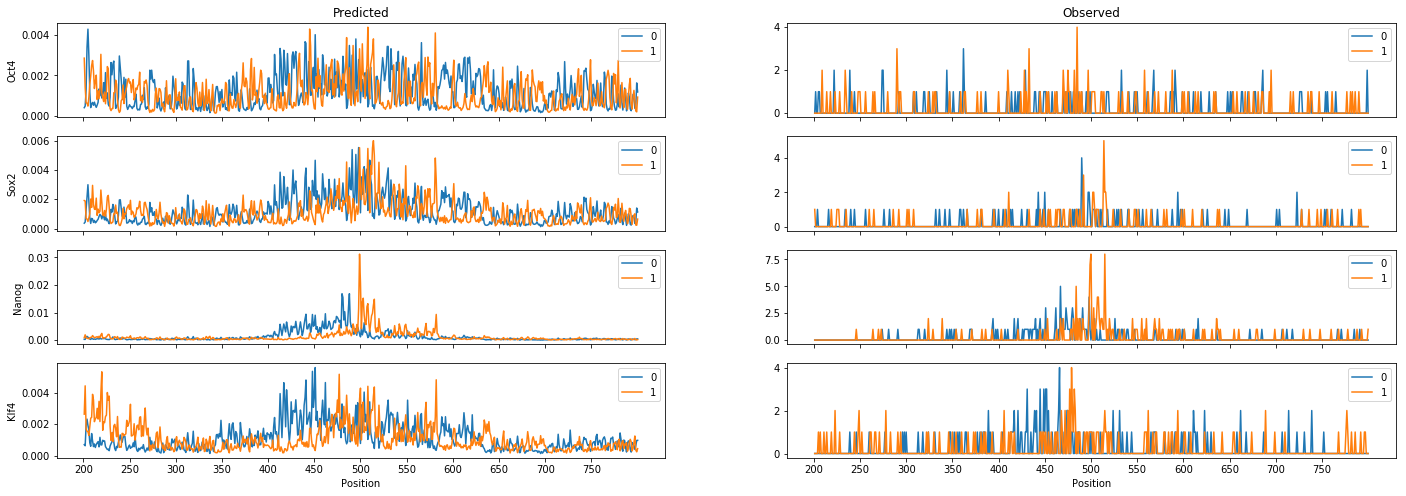

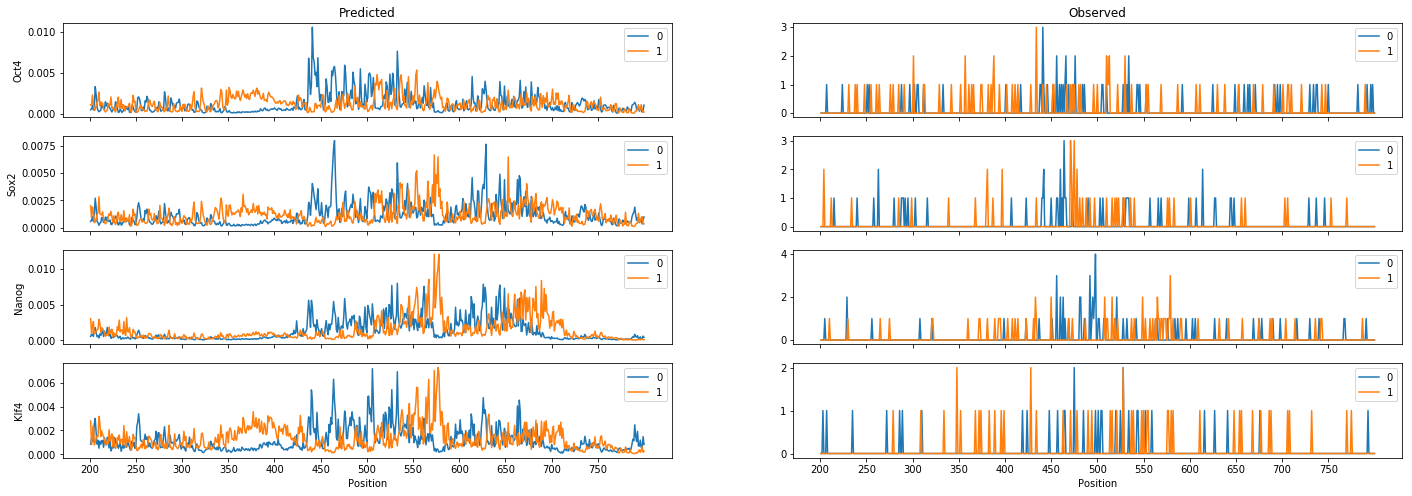

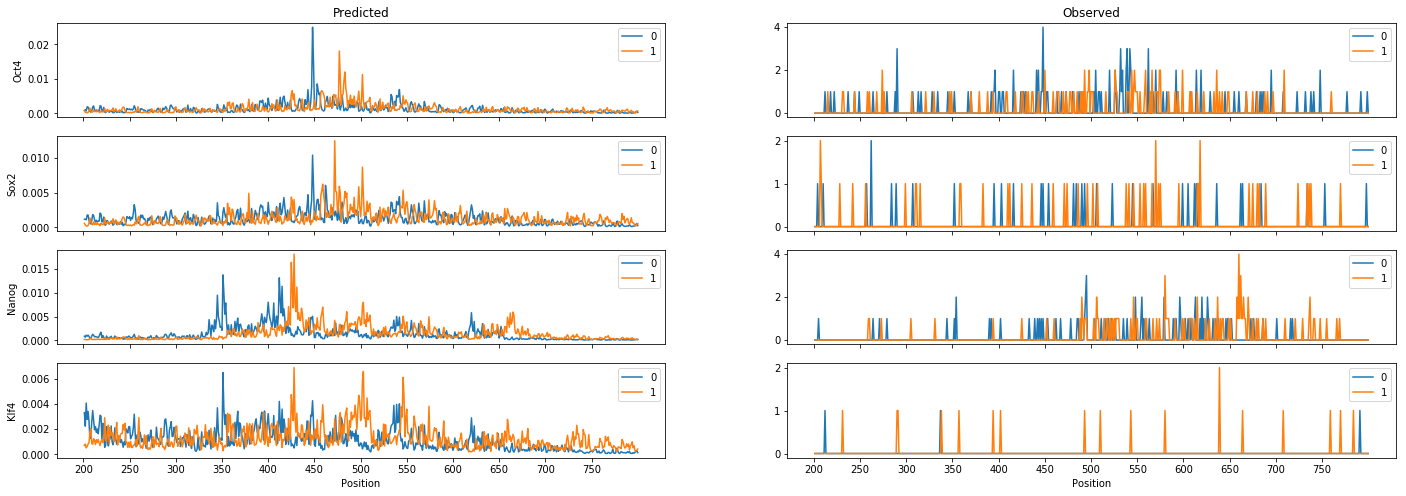

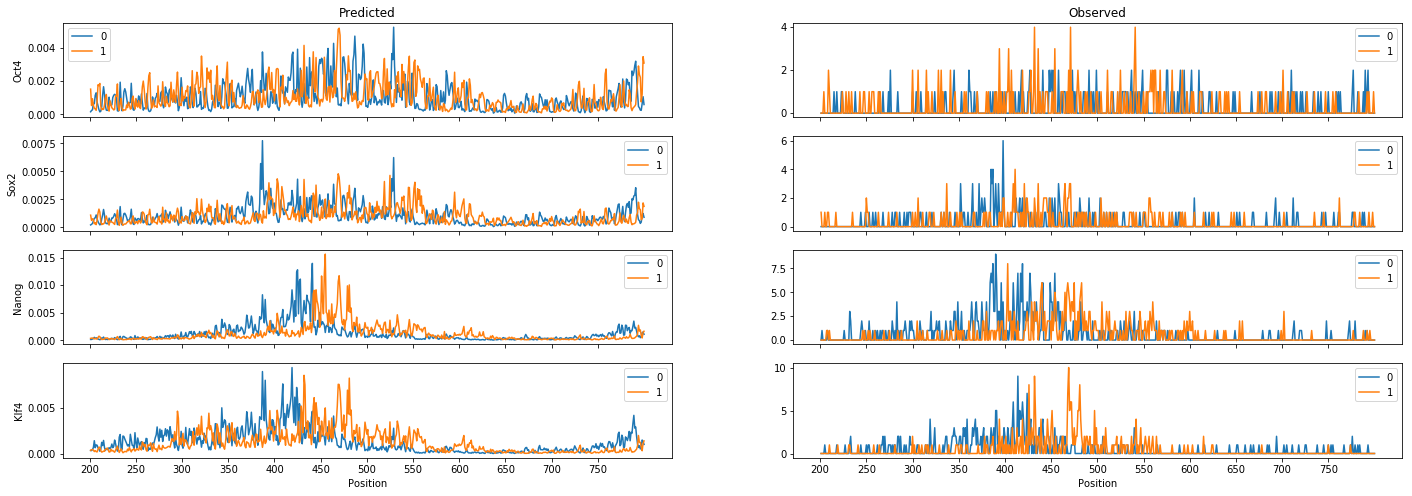

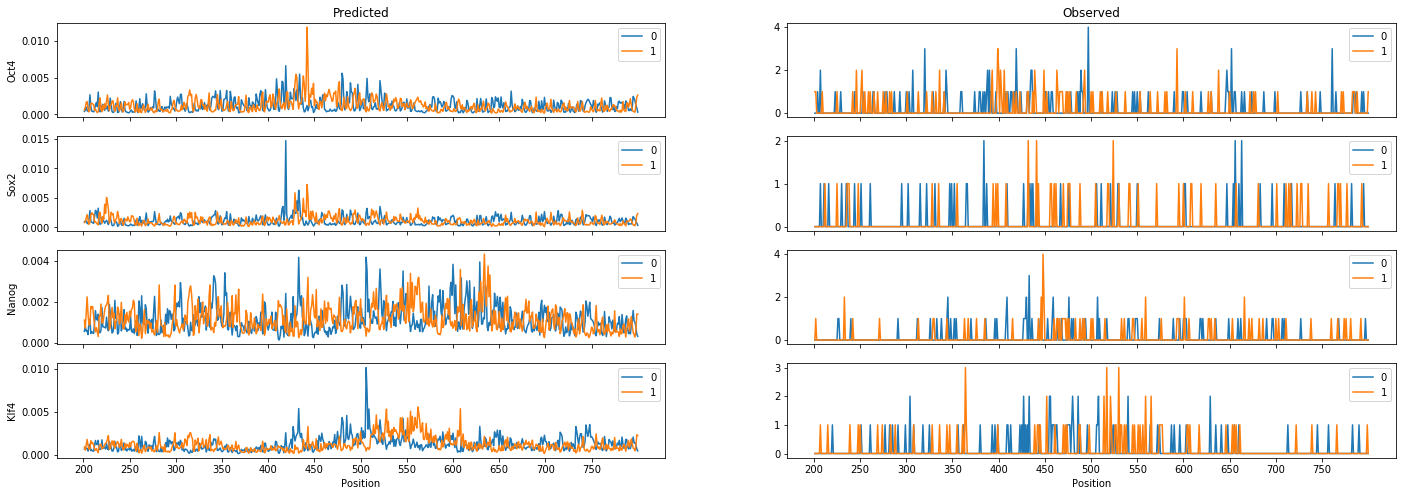

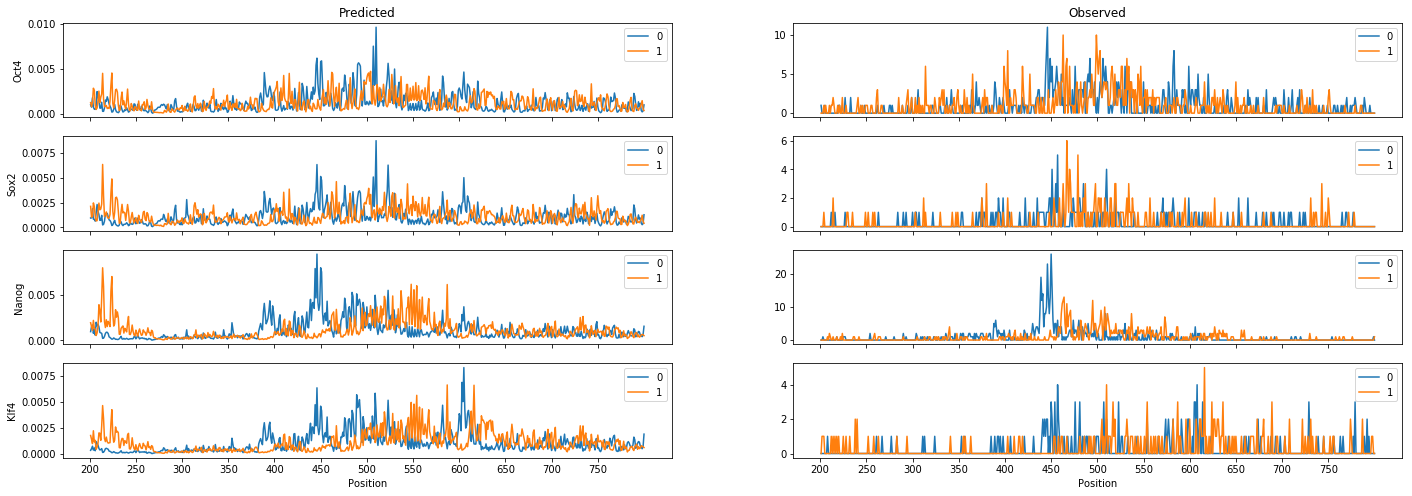

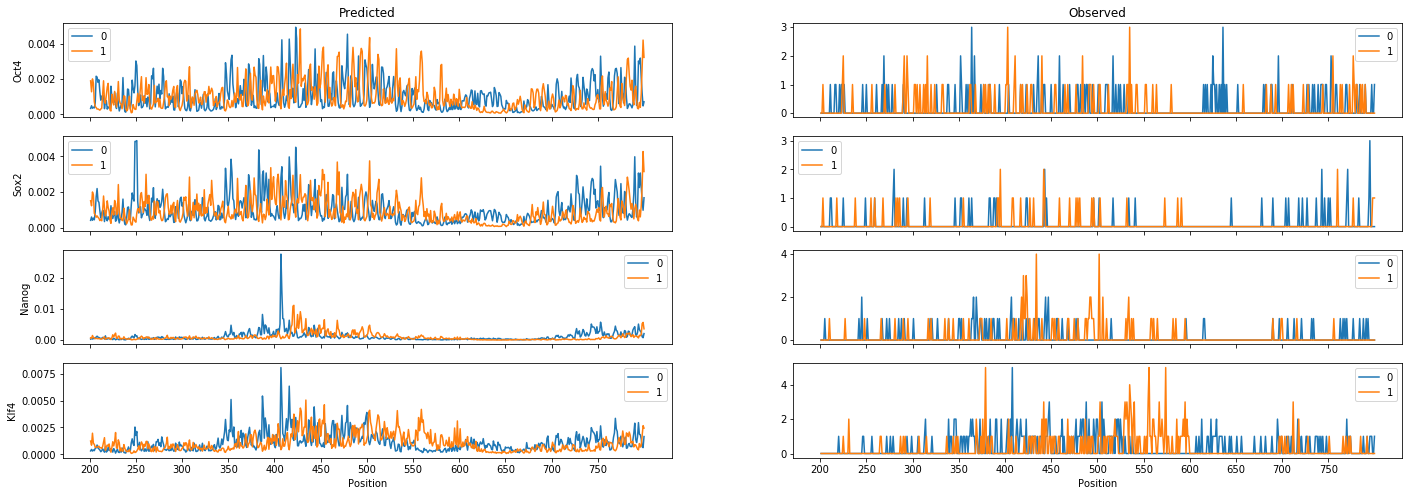

In [35]:
plot_profiles(y_true, y_pred, tasks, idx_list, preproc=None, figsize=(24, 8), tic_freq=50, 
              xlim=[int(np.floor(peak_width/5)),int(np.floor(peak_width/5*4))])